<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "IT-L6"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/IT-L6/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


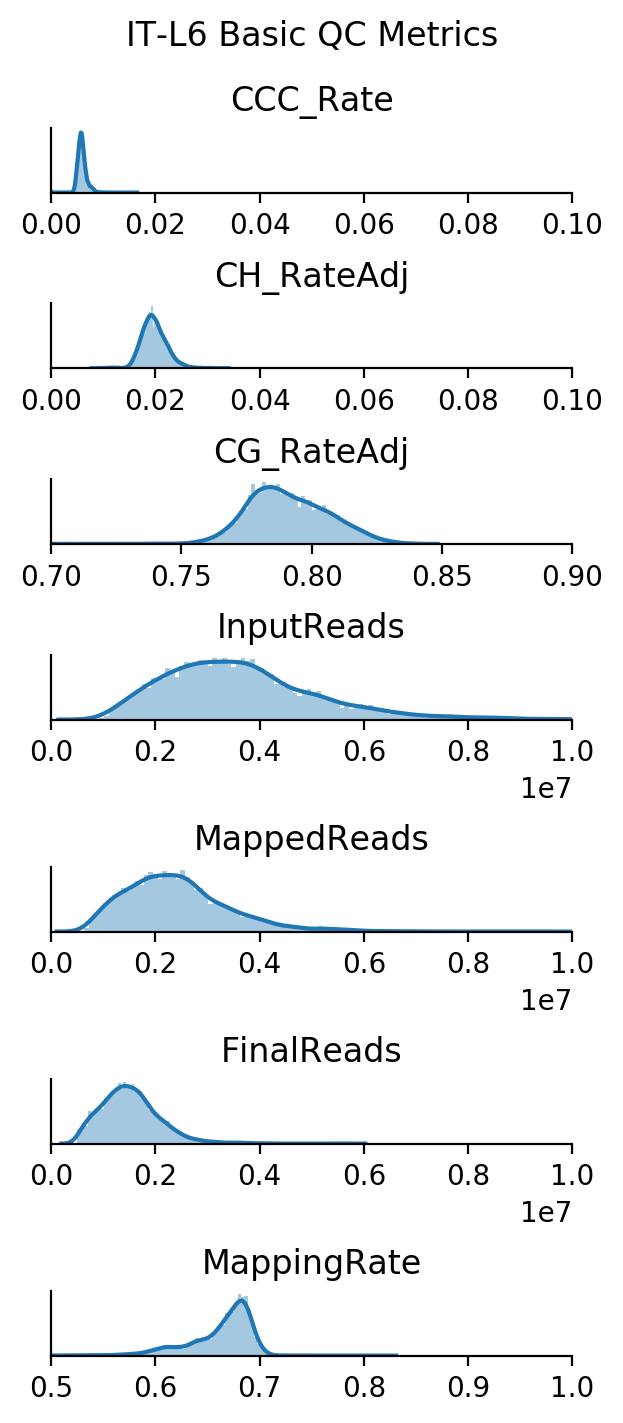

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

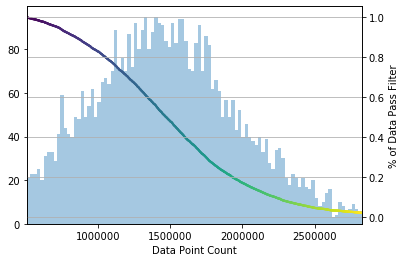

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 4947/4947 (100.0%)
CG_RateAdj passed 4947/4947 (100.0%)
CH_RateAdj passed 4947/4947 (100.0%)
FinalReads passed 4947/4947 (100.0%)
MappingRate passed 4947/4947 (100.0%)
Overall passed 4947/4947 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 124
171207 113
171212 30
171213 119
171214 22
171219 22
180104 119
180109 9
180119 32
180122 160
180123 163
180129 177
180130 144
180205 144
180206 159
180213 36
180220 14
180222 14
180226 11
180227 4
180305 106
180306 136
180312 152
180319 1
180320 10
180326 10
180329 1
180402 3
180403 3
180405 2
180409 21
180410 28
180412 93
180416 94
180417 122
180419 110
180423 133
180424 89
180426 112
180430 105
180501 104
180514 91
180529 123
180605 148
180612 138
180925 9
181002 146
181009 24
181022 135
181023 141
181204 1
181206 7
181210 158
181218 3
190108 134
190117 130
190122 126
190124 131
190131 16
190205 138
190214 2
190307 94
190716 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 595 154.9%
ad002 629 163.8%
ad004 652 169.8%
ad006 644 167.7%
ad007 593 154.4%
ad008 624 162.5%
ad010 644 167.7%
ad012 566 147.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
11E_M_1430,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.004947,0.754320,0.753098,0.015876,0.010983,788256.0,1693932,979765.0,11E,...,-4.683250,-27.240881,-31.107245,1.629382,IT-L6,14.178187,-5.705897,3.129238,-8.614209,True
11E_M_819,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.005486,0.785423,0.784239,0.021222,0.015822,1284706.0,3159416,2136658.0,11E,...,-4.443059,-29.038481,-41.175181,-0.065253,IT-L6,14.369918,-5.997719,4.236887,-7.958206,True
1A_M_117,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004680,0.772540,0.771470,0.021890,0.017290,1487833.0,3413778,2238071.0,1A,...,-13.184935,-31.339354,-8.781334,-20.426568,IT-L6,6.408087,-13.971183,-6.178516,1.776004,True
1A_M_1362,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004720,0.790500,0.789510,0.024070,0.019440,1823814.0,4192400,2839170.0,1A,...,-12.872609,-31.284628,-8.763298,-20.145619,IT-L6,6.632489,-14.048337,-6.010644,1.567544,True
1A_M_1509,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004850,0.770090,0.768970,0.022740,0.017980,1907350.0,4548888,3087713.0,1A,...,-13.156063,-31.336008,-8.752611,-20.292442,IT-L6,6.472377,-14.004743,-6.040867,1.591561,True
1A_M_1651,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004310,0.781720,0.780780,0.021110,0.016870,1218607.0,2751860,1832988.0,1A,...,-5.911784,-27.982681,-32.290775,-0.801972,IT-L6,13.706348,-7.302536,20.135786,-10.735200,True
1A_M_1961,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004830,0.761330,0.760170,0.024800,0.020070,1097606.0,2314794,1541615.0,1A,...,-6.359907,-28.747257,-33.750552,-3.460791,IT-L6,14.175493,-8.637341,20.975922,-5.025536,True
1A_M_2206,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.005220,0.784490,0.783360,0.026090,0.020980,1063330.0,2417678,1632239.0,1A,...,-6.523869,-28.617996,-32.987005,-3.137920,IT-L6,13.868658,-8.540973,21.666365,-6.291316,True
1A_M_221,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004980,0.769500,0.768350,0.025790,0.020910,1658189.0,3848716,2574195.0,1A,...,-6.551818,-29.192396,-34.189228,-4.434819,IT-L6,14.367922,-9.053878,21.254156,-4.171291,True
